# ReID For Pepper
In this notebook, I will try to implement very simple way to do ReIdentification of objects across pictures.

Here I build FeatureExtractor. This class will extract features of cropped image parts to help find visually and semantically similar parts of images for ReID.

In [23]:
import numpy as np
from numpy.typing import NDArray
from PIL import Image
import torch
from transformers import AutoModel
from transformers import CLIPImageProcessor


class FeatureExtractor:
    REPO = "nvidia/C-RADIOv4-SO400M"
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Loading {self.REPO} on {self.device}...")
        self.model = AutoModel.from_pretrained(
            self.REPO,
            trust_remote_code=True,
            dtype = torch.float16
        ).to(self.device).eval()
        self.processor = CLIPImageProcessor.from_pretrained(
            self.REPO,
            trust_remote_code=True
        )

    def resize(self, image: Image.Image, resampling_method: Image.Resampling, target_size: tuple[int, int] | None = None) -> Image.Image:
        """Image resizing method used to get the nearest supported resolution for Nvidia RADIO model"""
        if target_size is None:
            h, w = image.size[1], image.size[0]
            h2, w2 = self.model.get_nearest_supported_resolution(h, w)
            target_size = (w2, h2)
        return image.resize(target_size, resampling_method)

    @staticmethod
    def _normalize(tensor: torch.Tensor) -> torch.Tensor:
        return tensor / tensor.norm(p=2, dim=-1, keepdim=True)

    def forward(self, X: Image.Image | list[Image.Image], normalize:bool=True) -> NDArray:
        with torch.no_grad():
            pixel_values = self.processor(
                images=X, return_tensors='pt', do_resize=False
            ).pixel_values.to(torch.float16).cuda()
            # we dont care about features, really
            summary, _ = self.model(pixel_values)
            if normalize:
                summary = self._normalize(summary)
        return summary.cpu().numpy()

    # these two can be written as one...
    def get_embedding(self, image_crop: Image.Image, normalize: bool=True, resampling_method: Image.Resampling = Image.Resampling.BICUBIC, target_size: tuple[int, int] | None = None) -> np.ndarray:
        image_resized = self.resize(image_crop, resampling_method, target_size)
        return self.forward(image_resized, normalize)

    def get_embeddings_batch(self, image_crops: list[Image.Image], normalize: bool=True, resampling_method: Image.Resampling = Image.Resampling.BICUBIC, target_size: tuple[int, int] | None = None) -> np.ndarray:
        image_crops_resized = [self.resize(img, resampling_method, target_size) for img in image_crops]
        return self.forward(image_crops_resized, normalize)

Now I create simple dataclassses to represent Tracked objects and detection in the current frame

In [40]:
# dataclass breaks this down as it is not hashable
class Object:
    def __init__(self, obj_id, angle, embedding, label, bbox):
        self.obj_id = obj_id
        self.angle = angle
        self.embedding = embedding
        self.label = label
        self.bbox = bbox
    # obj_id: str | float | int
    # angle: float
    # embedding: NDArray | None # none because we will initialize with empty embedding sometime
    # label: str
    # bbox: list[float]
class TrackedObject(Object):
    pass
class Detection(Object):
    pass


Next, I define an Associator which will take the already tracked objects and match them with the new detections based on their similarity. I will also add, alongside the semantic relationship, a geometric relationship which presupposes the same objects are close to each other in the subsequent frames.

In [41]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

Matches = list[tuple[TrackedObject, Detection]]

class Associator:
    INF: float = 10_000.0
    def __init__(self, w_geo=0.001, w_vis=0.9, max_angle_diff=0.5):
        """weights of relationships + max angle diff"""
        self.w_geo = w_geo
        self.w_vis = w_vis
        self.max_angle_diff = max_angle_diff

    def get_cost_matrix(self, tracked_objs: list[TrackedObject], detections: list[Detection]) -> NDArray:
        cost_matrix = np.zeros((len(tracked_objs), len(detections)))
        for t, track in enumerate(tracked_objs):
            for d, det in enumerate(detections):
                # geometric
                angle_diff = abs(track.angle - det.angle)
                # visual
                vis_sim = cosine_similarity(
                    track.embedding.reshape(1, -1), det.embedding.reshape(1, -1)
                )[0][0]
                vis_cost = 1 - vis_sim

                if angle_diff > self.max_angle_diff:
                    # make it too costly to even consider
                    cost_matrix[t, d] = self.INF
                else:
                    cost_matrix[t, d] = (self.w_geo * angle_diff) + (
                            self.w_vis * vis_cost
                    )
        return cost_matrix


    def match(self, tracked_objs: list[TrackedObject], detections: list[Detection], match_cost_threshold: float = 0.4) -> tuple[Matches, list[Detection]]:
        """matches tracked objects and detections, returns Matches and list of unmatched detections. Uses hungarian algorithm to find the best matches in bipartite graph of TrackedObjects and Detections"""
        if not tracked_objs or not detections:
            return [], list(range(len(detections))) if not tracked_objs else []

        cost_matrix = self.get_cost_matrix(tracked_objs, detections)
        row_inds, col_inds = linear_sum_assignment(cost_matrix)
        matches = []
        matched_indices = set()
        # matched
        for t, d in zip(row_inds, col_inds, strict=True):
            if cost_matrix[t, d] <= match_cost_threshold:
                matches.append((tracked_objs[t], detections[d]))
                matched_indices.add(d)
        # unmatched
        unmatched_dets = [
            detections[d] for d in range(len(detections)) if d not in matched_indices
        ]
        return matches, unmatched_dets


In [42]:
from pathlib import Path

from ultralytics import RTDETR
from ultralytics.engine.results import Results


def get_crops(original_image: Image.Image, results: Results, confidence_threshold: float = 0.4) -> list[Image.Image]:
    crops = []
    for _obj_id, box in enumerate(results.boxes):
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = float(box.conf)
        if conf < confidence_threshold:
            continue
        crop = original_image.crop((x1, y1, x2, y2))
        crops.append(crop)
    return crops


def get_detections(results: Results, image_width: int, confidence_threshold: float = 0.4) -> list[Detection]:
    detections = []
    for obj_id, box in enumerate(results.boxes):
        conf = float(box.conf)
        if conf < confidence_threshold:
            continue
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        cls_id = int(box.cls)
        label = results.names[cls_id]
        x_center = (x1 + x2) / 2
        rel_angle = ((x_center / image_width) - 0.5) # + some angle offset if needed
        det = Detection(
            obj_id=obj_id, angle=rel_angle, embedding=None, label=label, bbox=[x1, y1, x2, y2]
        )
        detections.append(det)
    return detections


def detect_and_embed(image_path: Path, detector: RTDETR, extractor: FeatureExtractor, confidence_threshold: float = 0.4, embedding_kwargs:dict = None) -> list[Detection]:
    if embedding_kwargs is None:
        embedding_kwargs = {}
    pil_img = Image.open(image_path).convert("RGB")
    w, _ = pil_img.size
    results = detector(image_path, verbose=False)[0]
    crops = get_crops(pil_img, results, confidence_threshold)
    detections = get_detections(results, w, confidence_threshold)
    # assign embeddings in batch
    if crops:
        embeddings = extractor.get_embeddings_batch(crops, **embedding_kwargs)
        for i, det in enumerate(detections):
            det.embedding = embeddings[i]
    return detections

In [43]:
import cv2
import supervision as sv


def visualize_frame(image_path: Path, detections: list[Detection], track_map: dict[Detection, int], title_text: str):
    """Track map maps Detection to tracked obj id"""
    image = cv2.imread(image_path)
    boxes = []
    ids = []
    labels = []
    for det in detections:
        boxes.append(det.bbox)
        tid = track_map.get(det, det.obj_id)
        ids.append(tid)
        labels.append(f"#{tid} {det.label}")
    if not boxes:
        return image
    sv_dets = sv.Detections(
        xyxy=np.array(boxes),
        tracker_id=np.array(ids)
    )
    box_annotator = sv.BoxAnnotator(thickness=4, color_lookup=sv.ColorLookup.TRACK)
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2, color_lookup=sv.ColorLookup.TRACK)

    frame_viz = box_annotator.annotate(scene=image.copy(), detections=sv_dets)
    frame_viz = label_annotator.annotate(scene=frame_viz, detections=sv_dets, labels=labels)

    cv2.putText(frame_viz, title_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 4)
    cv2.putText(frame_viz, title_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return frame_viz

Experiment setup

In [44]:
IMG_TARGET_SIZE = (384, 384)
CONF_THRESHOLD = 0.4
MAX_ANGLE_DIFF = 1.5 # huge angle diff to check all sorts of pairs
MATCH_COST_THRESHOLD = 0.4

EMBEDDING_KWARGS = {
    "normalize": True,
    "resampling_method": Image.Resampling.BICUBIC,
    "target_size": IMG_TARGET_SIZE,
}

detector = RTDETR("rtdetr-l.pt")
extractor = FeatureExtractor()
associator = Associator(max_angle_diff=MAX_ANGLE_DIFF)

Loading nvidia/C-RADIOv4-SO400M on cuda...


Loading weights: 100%|██████████| 330/330 [00:00<00:00, 1516.45it/s, Materializing param=radio_model.summary_idxs]                         


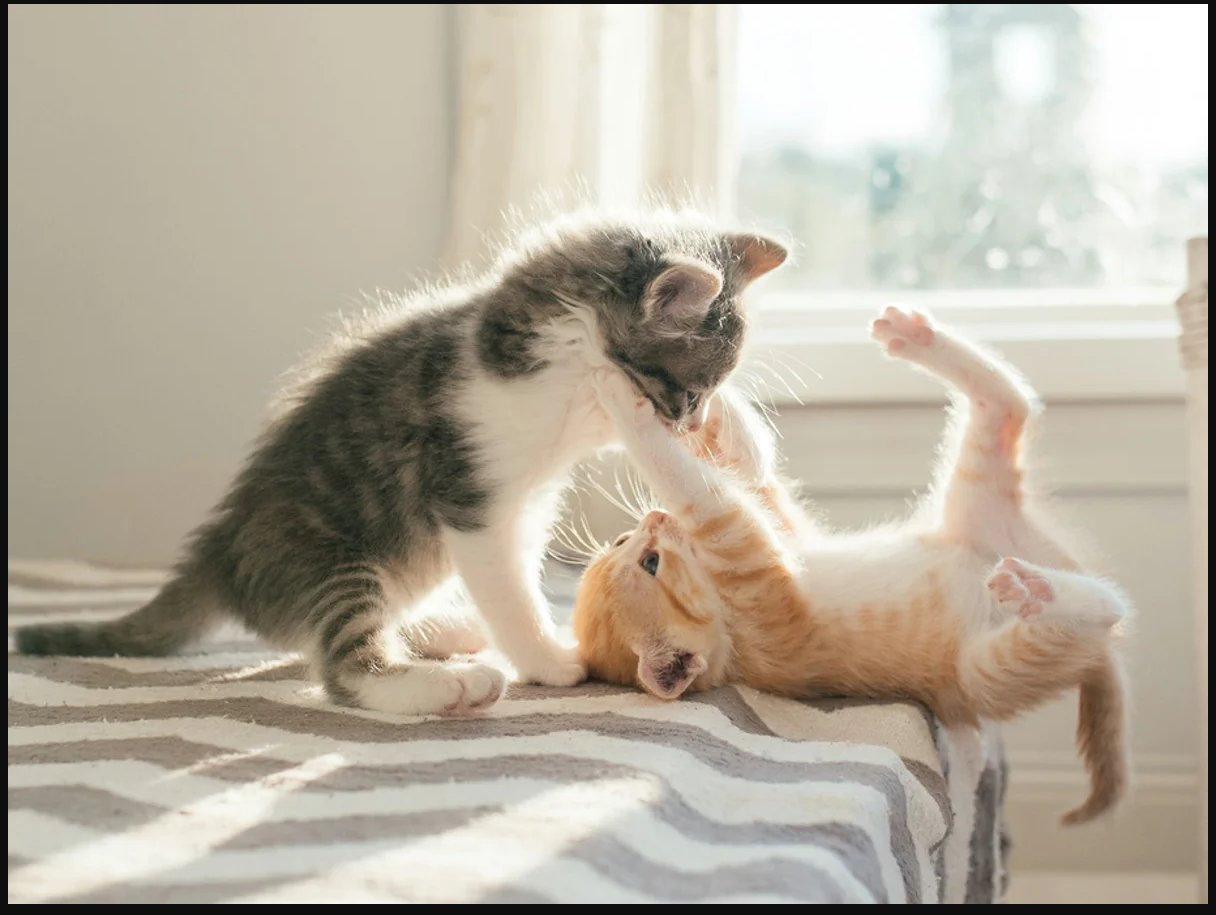

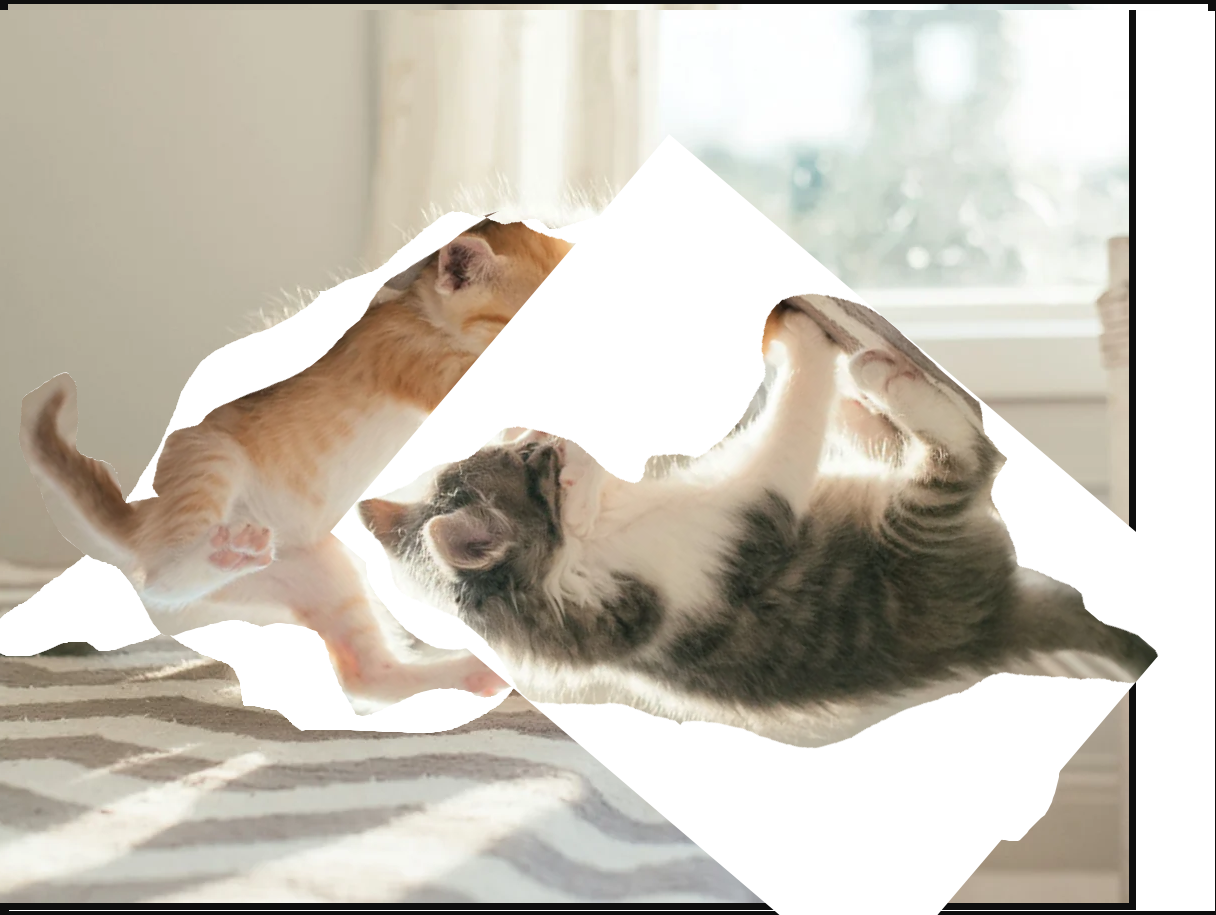

In [45]:
from IPython.display import Image as IImage
from IPython.display import display

image_files = [
        Path("data/in/cats.png"),
        #"data/in/cats2.png",
        Path("data/in/cats3.png"),
]
for img in image_files:
    display(IImage(filename=str(img)))

We suppose that the image order in the list defines how they are perceived by the robot

In [54]:
import time

start = time.time()

tracks = []
next_track_id = 1
visualizations = []
for frame_idx, img_path in enumerate(image_files):
    print(f"Processing Frame {frame_idx + 1}: {img_path}")
    detections = detect_and_embed(img_path, detector, extractor, CONF_THRESHOLD, EMBEDDING_KWARGS)
    print(f"Detected {len(detections)} objects.")
    track_map_for_viz = {}
    match frame_idx:
        case 0: # first frame
            for det in detections:
                new_track = TrackedObject(
                    obj_id=next_track_id,
                    angle=det.angle,
                    embedding=det.embedding,
                    label=det.label,
                    bbox=det.bbox
                )
                tracks.append(new_track)
                track_map_for_viz[det] = next_track_id  # Det maps to its new Track ID
                print(f"Initialized Track #{next_track_id} ({det.label})")
                next_track_id += 1
        case _: # other frames
            matches, unmatched = associator.match(tracks, detections, MATCH_COST_THRESHOLD)
            for trk, det in matches:
                track_map_for_viz[det] = trk.obj_id
            # unmatched = new objs
            for det in unmatched:
                new_track = TrackedObject(
                    obj_id=next_track_id,
                    angle=det.angle,
                    embedding=det.embedding,
                    label=det.label,
                    bbox=det.bbox
                )
                tracks.append(new_track)
                track_map_for_viz[det] = next_track_id
                print(f"New Object Found! Created Track #{next_track_id} ({det.label})")
                next_track_id += 1 # adding new ids
    viz = visualize_frame(img_path, detections, track_map_for_viz, f"Frame {frame_idx + 1}")
    visualizations.append(viz)
elapsed = time.time() - start

print("Elapsed time: ", elapsed)

Processing Frame 1: data/in/cats.png
Detected 3 objects.
Initialized Track #1 (cat)
Initialized Track #2 (cat)
Initialized Track #3 (bed)
Processing Frame 2: data/in/cats3.png
Detected 2 objects.
Elapsed time:  0.8959629535675049


In [55]:
h1, w1 = visualizations[0].shape[:2]
resized_viz = [visualizations[0]]

for v in visualizations[1:]:
    h, w = v.shape[:2]
    if h != h1:
        scale = h1 / h
        v = cv2.resize(v, (int(w * scale), h1))
    resized_viz.append(v)

final_image = np.hstack(resized_viz)

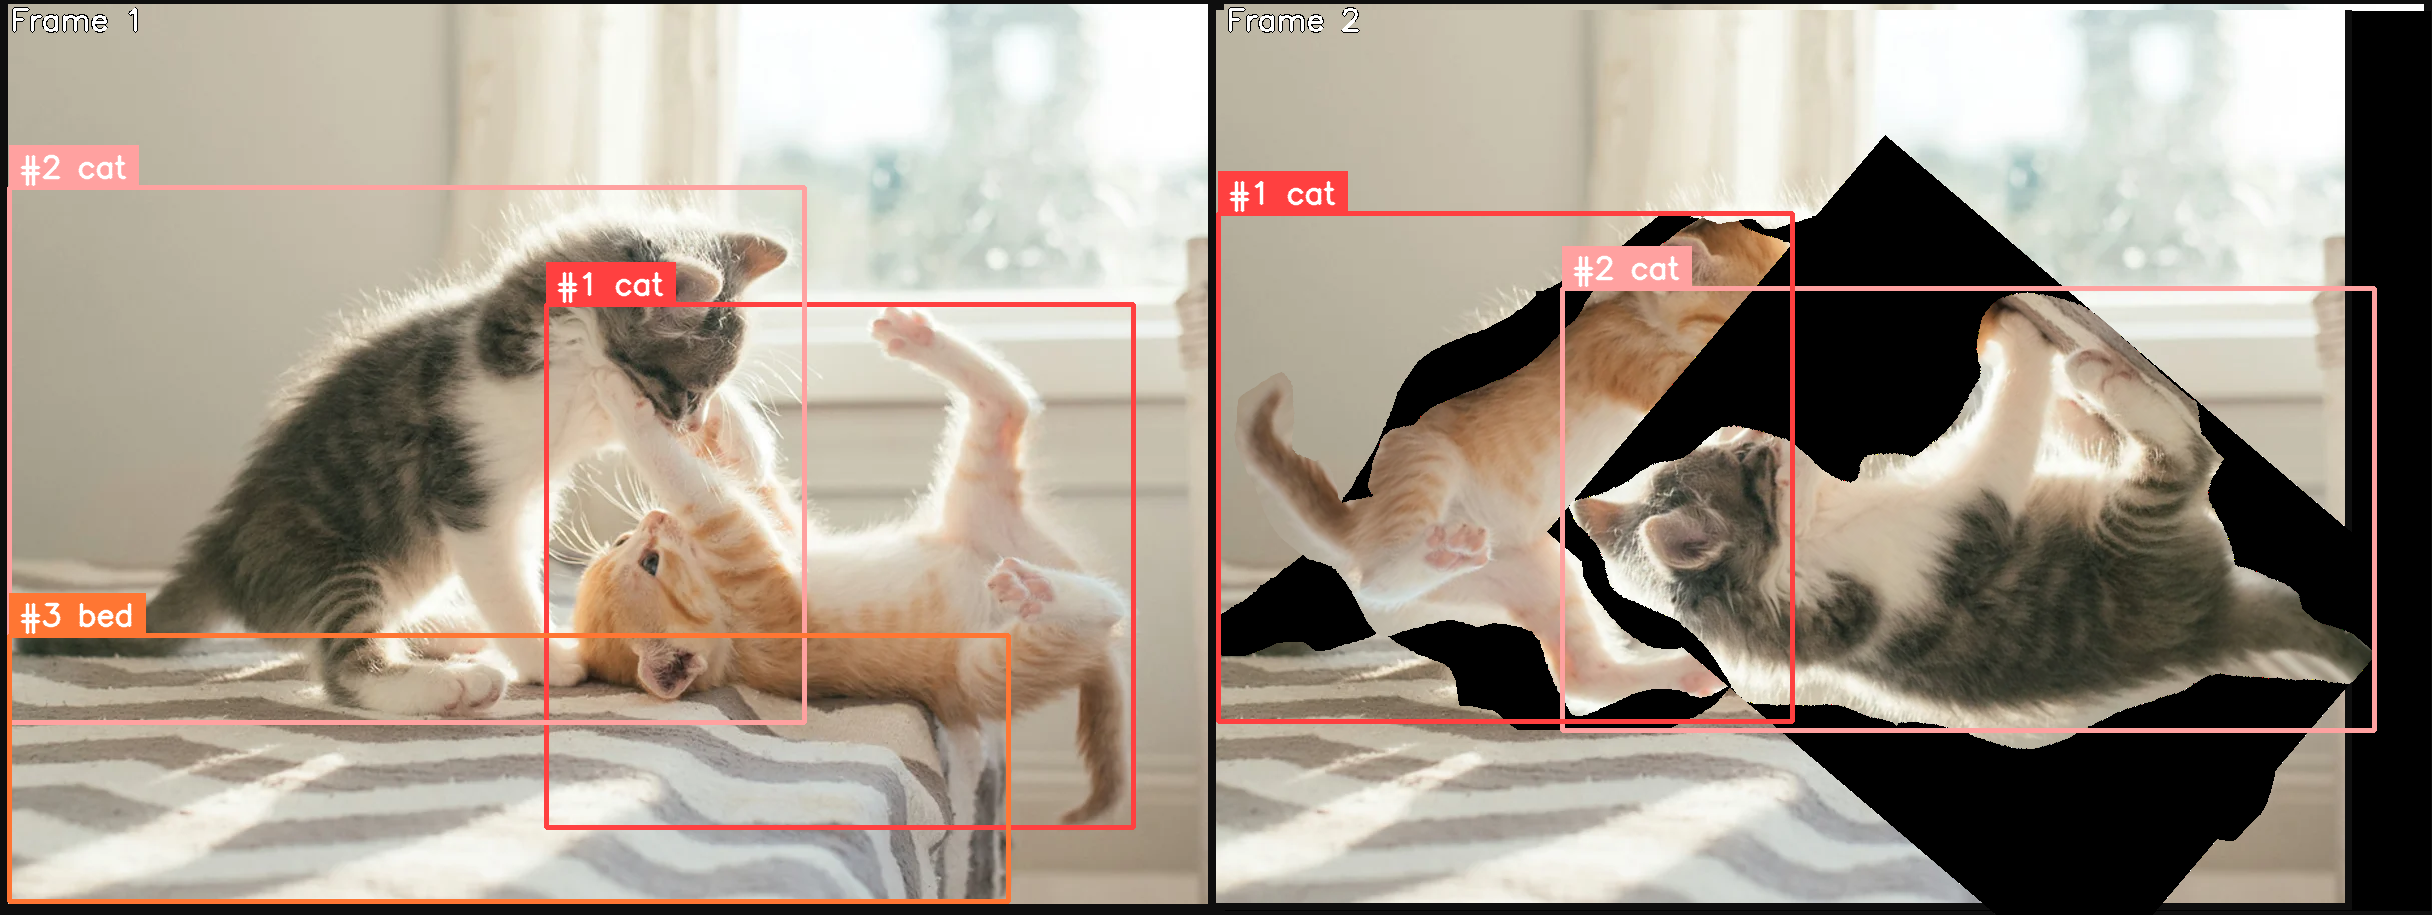

In [56]:
final_image = np.hstack(resized_viz)
cv2.imwrite("data/out/final_image.png", final_image)
display(IImage("data/out/final_image.png"))

It seems to work :)